### Introduction

A list of the resources I used:
- Good reference to understand the terms used in RL: https://towardsdatascience.com/the-complete-reinforcement-learning-dictionary-e16230b7d24e
- Article useful for building a custom environment based off an example that isn't a game: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e 
- OpenAI Gym Documentation: https://www.gymlibrary.ml 
- Stable Baselines 3 Documentation (Page is the chosen model): https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#stable_baselines3.dqn.CnnPolicy 
- A good two part tutorial: https://towardsdatascience.com/ultimate-guide-for-reinforced-learning-part-1-creating-a-game-956f1f2b0a91  
- All about DQN: https://avandekleut.github.io/dqn/ 



In [107]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString, Point
import random
import time
from rasterio.features import rasterize
from IPython import display
import geopandas as gpd
import pandas as pd

%matplotlib inline

font = cv2.FONT_ITALIC
os.chdir('/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method')

### General Functions


In [8]:
def crop_image(image,y_start,x_start,height,width):
    return image[y_start:y_start+height,x_start:x_start+width]

def rect_out_rast(y,x,height,width):
    p = Polygon([[x, y], [x+width, y+0], [x+width, y+height], [x+0, y+height]])
    return rasterize([p],out_shape=(width,height))

def Sum_of_squared_differences(roi,temp):
    ssd = np.sum((roi-temp)**2)
    return ssd

def action_rules(action):
    if action==None:
        return action
    elif action<4:
        return action+4
    else:
        return action-4

def tuple_addition(a,b):
    return tuple(map(sum, zip(a, b)))

### General Classes

In [106]:
class Point2(object):
    def __init__(self, name, y_max, x_max, y_min, x_min):
        self.y = 0
        self.x = 0
        self.y_max = y_max
        self.x_max = x_max
        self.y_min = y_min
        self.x_min = x_min
        self.name = name
    
    def set_position(self, y, x):
        self.y = self.clamp(y, self.y_min, self.y_max)
        self.x = self.clamp(x, self.x_min, self.x_max)
    
    def get_position(self):
        return (self.y, self.x)
    
    def move(self, del_y, del_x):
        self.y += del_y
        self.x += del_x
        
        self.y = self.clamp(self.y, self.y_min, self.y_max)
        self.x = self.clamp(self.x, self.x_min, self.x_max)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)
    
class Frame(Point2):
    def __init__(self,name,y_max, x_max, y_min, x_min, T_HEIGHT, T_WIDTH):
        super(Frame, self).__init__(name, y_max, x_max, y_min, x_min)
        self.icon = cv2.cvtColor(rect_out_rast(y_min,x_min,T_HEIGHT,T_WIDTH), cv2.COLOR_GRAY2RGB)
        self.T_WIDTH = T_WIDTH
        self.T_HEIGHT = T_HEIGHT
        # self.icon = cv2.imread(os.path.join(os.getcwd(),"notebooks","chopper.png")) / 255
        self.icon = cv2.resize(self.icon, (self.T_WIDTH, self.T_HEIGHT)) #cv2 resize method is width then height



### Sandbox

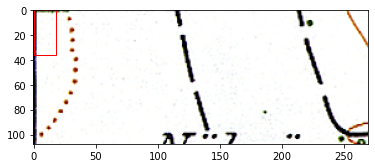

In [32]:
p = patches.Rectangle((0,
                        0), #origin
                        18, #x-dimension
                        36, #y-dimension
                        linewidth=1, 
                        edgecolor='r', 
                        facecolor='None',
                        rasterized=True)


fig, ax = plt.subplots()
x = 0
y = 0
ax.imshow(image_norm[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

# Create a Rectangle patch
ax.add_patch(p)

### Load Data

In [4]:

path_sample_image = './data/tif_files/LKg_1092_1990.tif'
path_sample_template_1 = './data/templates/temp_1.tif'
path_sample_template_2 = './data/templates/temp_2.tif'

path_testing_image = './data/testing/testing_board.tif'
path_testing_template_1 = './data/testing/testing_template.tif'

image = cv2.imread(path_sample_image)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_grey = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
image_norm = (image_color/255).astype(float)

template =cv2.imread(path_sample_template_1)
template_color = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template_grey = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)
template_norm = (template_color/255).astype(float)

test_image = cv2.imread(path_testing_image)
test_image_color = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_grey = cv2.cvtColor(test_image_color, cv2.COLOR_BGR2GRAY)
test_image_norm = (test_image_color/255).astype(float)

test_template =cv2.imread(path_testing_template_1)
test_template_color = cv2.cvtColor(test_template, cv2.COLOR_BGR2RGB)
test_template_grey = cv2.cvtColor(test_template_color, cv2.COLOR_BGR2GRAY)
test_template_norm = (test_template_color/255).astype(float)




I_HEIGHT, I_WIDTH, I_DEPTH = image.shape
T_HEIGHT, T_WIDTH, T_DEPTH = template.shape

print('Data Type: %s' % image_norm.dtype)
print('Min: %.3f, Max: %.3f' % (image_norm.min(), image_norm.max()))


Data Type: float64
Min: 0.000, Max: 1.000


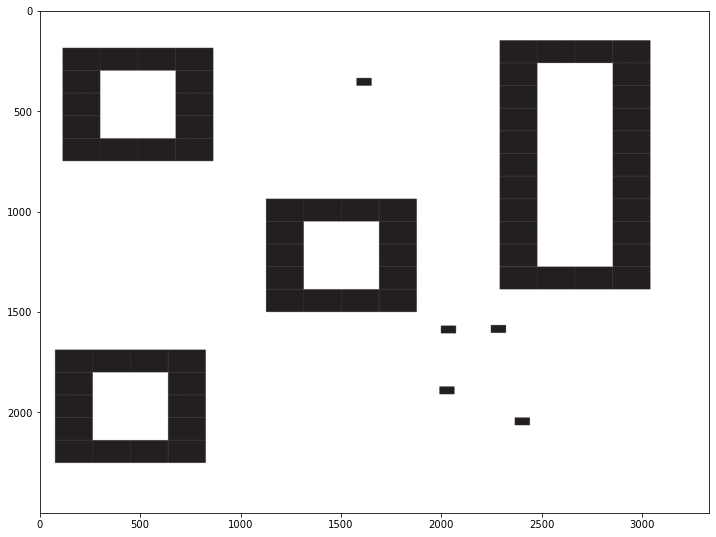

In [5]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(test_image_norm)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w

### Inspect Map

In [36]:
x,y = 0,0
print(y,y+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)

0 18
0 45
----------
18 36
-45 0
----------
0 18
-45 0
----------
-18 0
-45 0
----------
-18 0
0 45
----------
-18 0
45 90
----------
0 18
45 90
----------
18 36
45 90
----------
18 36
0 45


In [37]:
x,y = int(0),int(0)

def calc_surround_origins(x,y,T_WIDTH,T_HEIGHT):
    origins = [(x,y),
            (x-T_WIDTH,y+T_HEIGHT),
            (x-T_WIDTH,y),
            (x-T_WIDTH,y-T_HEIGHT),
            (x,y-T_HEIGHT),
            (x+T_WIDTH,y-T_HEIGHT),
            (x+T_WIDTH,y),
            (x+T_WIDTH,y+T_HEIGHT),
            (x,y+T_HEIGHT)]
    return origins

def calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT):
    all_surround = [image[y:y+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH]]
    return all_surround[1:]
    

def find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT):
    mask = []
    for n,t in enumerate(calc_surround_origins(x,y,T_WIDTH,T_HEIGHT)):
        if t[0] < 0 or t[1] < 0:
            pass
        else:
            mask.append(n)
    all_surround = calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT)
    
    return [all_surround[i] for i in mask]


find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT)

IndexError: list index out of range

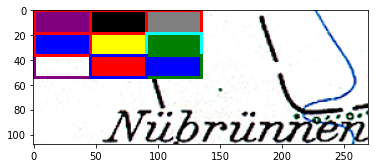

In [ ]:
colos = []
fig, ax = plt.subplots()

ax.imshow(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

x,y = 45,18
# Create a Rectangle patch
ax.add_patch(patches.Rectangle((x,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='y', 
                         facecolor='yellow'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='purple', 
                         facecolor='none'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='purple'))

ax.add_patch(patches.Rectangle((x,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='black'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='grey'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='cyan', 
                         facecolor='green'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='g', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='b', 
                         facecolor='red'))

In [ ]:
template = cv2.imread(path_temp,0)

height, width = template.shape
loc, res = template_matching(image,template,default_threshold, method)

for (x,y) in zip(loc[0], loc[1]):
    cv2.rectangle(image_color, (x,y), (x+width, y+height), (0,0,255), 2)

### Building Environment

Built off the boilerplate in: 

https://blog.paperspace.com/creating-custom-environments-openai-gym/


In [61]:
a = np.linspace(0,image.shape[0],int(np.floor(image.shape[0]/template.shape[0])),dtype="int16")
a[a>36]

array([  54,   72,   90,  108,  126,  144,  162,  180,  198,  216,  234,
        252,  270,  288,  306,  324,  342,  360,  378,  396,  415,  433,
        451,  469,  487,  505,  523,  541,  559,  577,  595,  613,  631,
        649,  667,  685,  703,  721,  739,  757,  775,  793,  812,  830,
        848,  866,  884,  902,  920,  938,  956,  974,  992, 1010, 1028,
       1046, 1064, 1082, 1100, 1118, 1136, 1154, 1172, 1190, 1209, 1227,
       1245, 1263, 1281, 1299, 1317, 1335, 1353, 1371, 1389, 1407, 1425,
       1443, 1461, 1479, 1497, 1515, 1533, 1551, 1569, 1587, 1606, 1624,
       1642, 1660, 1678, 1696, 1714, 1732, 1750, 1768, 1786, 1804, 1822,
       1840, 1858, 1876, 1894, 1912, 1930, 1948, 1966, 1984, 2003, 2021,
       2039, 2057, 2075, 2093, 2111, 2129, 2147, 2165, 2183, 2201, 2219,
       2237, 2255, 2273, 2291, 2309, 2327, 2345, 2363, 2381, 2400, 2418,
       2436, 2454, 2472, 2490, 2508, 2526, 2544, 2562, 2580, 2598, 2616,
       2634, 2652, 2670, 2688, 2706, 2724, 2742, 27

In [220]:
class TemplateMatchingEnv(gym.Env):
    def __init__(self, image, template, obs_shape_mult=(3,3),sim_threshold=1000):
        super(TemplateMatchingEnv, self).__init__()
        self.image = image
        # self.reward_range = (0, 100000000)
        self.sim_threshold = sim_threshold
        
        # load template details
        self.template_array = template
        self.T_HEIGHT, self.T_WIDTH, self.T_DEPTH = self.template_array.shape
        # print(f"T_Height is {self.T_HEIGHT}")
        # print(f"T_Width is {self.T_WIDTH}")
        # set observation shape 
        self.obs_space_height = self.T_HEIGHT*obs_shape_mult[0]
        self.obs_space_width = self.T_WIDTH*obs_shape_mult[1]
        # print(f"Obs_num_cols is {self.obs_space_width}")
        # print(f"Obs_num_rows is {self.obs_space_height}")
        
        self.obs_shape_mult_height = obs_shape_mult[0]
        self.obs_shape_mult_width = obs_shape_mult[1]
        
        # Define a 2-D observation space
        self.observation_shape = (self.obs_space_height,
                                  self.obs_space_width,
                                  3)

        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Action to choose the next agent location 
        # 0 -> 8 corresponds to the list of neighbor frames 
        self.action_space = spaces.Discrete(8)
        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum moves the frame can make before resetting
        self.max_moves = 8
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the frame on canvas
        # for elem in self.elements:
        # elem_shape = self.frame.icon.shape
        # x,y = self.frame.x, self.frame.y
        self.canvas = self.image_array
        # self.canvas[y:y + elem_shape[0], x:x + elem_shape[1]] = self.frame.icon

        text = f"Turns Remaining: {self.moves_left} | Rewards: {self.ep_return}"

        # Put the info on canvas 
        # self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
        #         0.8, (0,0,0), 1, cv2.LINE_AA)

    def reset(self):
        print('Reset')
        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1
        self.image_array = None
        self.previous_action = None
        self.moves_taken = 0
        self.points = []
        self.moves = []
        self.actions = np.arange(0,self.action_space.n)
        
        # Reset the moves allowed
        self.moves_left = self.max_moves

        # Reset the reward
        self.ep_return  = 0

        # Intialise the frame
        
        # origin point for frame
        self.frame_y_origin = int(np.floor(self.obs_shape_mult_height/2)) * self.T_HEIGHT
        self.frame_x_origin = int(np.floor(self.obs_shape_mult_width/2)) * self.T_WIDTH
        # print(self.frame_y_origin,self.frame_x_origin)
        
        # crop image to observation space
        self.image_height, self.image_width, self.image_depth = self.image.shape
        self.height_buffer = self.T_HEIGHT*(self.obs_shape_mult_height+1)
        self.width_buffer = self.T_WIDTH*(self.obs_shape_mult_width+1)
        self.y_max = self.image_height-(self.height_buffer)
        self.x_max = self.image_width-(self.width_buffer)
        
        self.lin_y = np.linspace(0,self.image_height,int(np.floor(
            self.image_height/self.T_HEIGHT)),dtype="int16")
        self.lin_x = np.linspace(0,self.image_width,int(np.floor(
            self.image_width/self.T_WIDTH)),dtype="int16")
        
        
        self.random_y_origin = random.choice(self.lin_y[self.lin_y<+self.y_max]) # random.randint(0, self.y_max)
        self.random_x_origin = random.choice(self.lin_x[self.lin_x<+self.x_max]) # random.randint(0, self.x_max)
        self.episode_origin = (self.random_y_origin,self.random_x_origin)
        # self.previous_point = self.episode_origin
        self.points.append(self.episode_origin)
        # print(self.random_y_origin,self.random_x_origin)
        
        self.image_array = crop_image(self.image,
                                      self.random_y_origin,
                                      self.random_x_origin,
                                      self.obs_space_height,
                                      self.obs_space_width)
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_array.shape



        # Initialise the analysis frame
        self.frame = Frame('frame',
                           self.y_max,
                           self.x_max,
                           self.frame_y_origin,
                           self.frame_x_origin,
                           self.T_HEIGHT,
                           self.T_WIDTH)
        self.frame.set_position(self.frame_y_origin,self.frame_x_origin)

        # Intialise the elements 
        self.elements = [self.image_array,self.frame]

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # return the observation
        return self.canvas 
        
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            plt.imshow(self.canvas)
        
        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    def get_action_meanings(self):
        return {0: "South", 1: "Southwest", 2: "West", 3: "Northwest",
                4: "North", 5: "Northeast", 6: "East", 7: "Southeast"}
    
    def test_ssd_match(self):
    
        self.frame_array = crop_image(self.image_array,
                                 self.frame_y_origin,
                                 self.frame_x_origin,
                                 self.T_HEIGHT,
                                 self.T_WIDTH)
        
        self.ssd_ = Sum_of_squared_differences(self.frame_array,self.template_array)
        # result_.append(ssd_) # log results
        res = self.ssd_
        print(f"SSD result is {res}")
        if res>self.sim_threshold:
            return True

        return False
        
    def generate_possible_pts(self):
        all_moves = [(self.T_HEIGHT,0),
                          (self.T_HEIGHT,self.T_WIDTH*-1),
                          (0,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,0),
                          (self.T_HEIGHT*-1,self.T_WIDTH),
                          (0,self.T_WIDTH),
                          (self.T_HEIGHT,self.T_WIDTH)]
        self.poss_pts = [tuple_addition(self.previous_point,pt) for pt in all_moves]
        return self.poss_pts
    
    def update_after_move(self):
        
        # store some data
        self.previous_action = self.action
        self.updated_point = tuple_addition(self.previous_point,self.movement)
        self.points.append(self.updated_point)
        self.moves.append(self.get_action_meanings()[self.action])
        # move the image array   
        self.image_array = crop_image(self.image,
                                      self.random_y_origin + self.movement[0],#self.frame_y
                                      self.random_x_origin + self.movement[1],#self.frame_x
                                      self.obs_space_height,
                                      self.obs_space_width)
    
    def step(self):
        self.possible_actions = self.actions
        # Flag that marks the termination of an episode
        done = False
        # Assert that it is a valid action 
        # assert self.action_space.contains(action), "Invalid Action"

        if self.moves_taken < 1:
            self.previous_point = self.episode_origin
        else:
            self.previous_point = self.updated_point

        # Decrease the moves left 
        self.moves_left -= 1 
        self.moves_taken += 1 
        print(f"Moves left, {self.moves_left}")
        
        for n,pt in enumerate(self.generate_possible_pts()):
            if pt==self.episode_origin:
                pass
            elif pt in self.points:
                np.delete(env.possible_actions,[n])
                
        if len(self.possible_actions)==0:
            print('No actions possible')
            done = True
            
        self.action = random.choice(self.possible_actions)
        
        # apply the action to the frame
        print(f"Action is {self.action}, {self.get_action_meanings()[self.action]}")
        if self.action == 0: # south
            self.movement = (self.T_HEIGHT,0)
        elif self.action == 1: # southwest
            self.movement = (self.T_HEIGHT,self.T_WIDTH*-1)
        elif self.action == 2: # west
            self.movement = (0,self.T_WIDTH*-1)
            #self.frame.move(0,T_WIDTH*-1)
        elif self.action == 3: # northwest
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH*-1)
        elif self.action == 4: # north
            self.movement = (self.T_HEIGHT*-1,0)
        elif self.action == 5: # northeast
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH)
        elif self.action == 6: # east
            self.movement = (0,self.T_WIDTH)
        elif self.action == 7: # southeast
            self.movement = (self.T_HEIGHT,self.T_WIDTH)
        
        self.update_after_move()
        match_ = self.test_ssd_match() # crop is done in function
        if match_ is True:
            print("Match")
            # Reward for a match.
            reward_a = 1
            # Reward for contiguous matches.
            reward_b = 1 * self.moves_taken
            reward = reward_a+reward_b
            
            if self.points[0] == self.points[-1]:
                print('Episode origin point visited. Loop created. Next Episode')
                reward += self.moves_taken**2
                
                # Increment the episodic return
                self.ep_return += reward

                # Draw elements on the canvas
                self.draw_elements_on_canvas()
                self.moves_left = 0
                done = True
            else:
                # Reset the moves allowed
                self.moves_left = self.max_moves
        else:
            print('No match, next epsiode')
            reward = 0
            done = True
        
        
        
        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of moves, end the episode.
        if self.moves_left == 0:
            done = True

        return self.canvas, reward, done, []
    
        

In [196]:
points = [(1,1),(2,3),(5,6)]
pt = (1,1)
if pt in points:
    print('contains')
for n,pt in enumerate(points):
    print(n)
    
del points[1]

points

contains
0
1
2


[(1, 1), (5, 6)]

In [228]:
# global variables
SIMILARTY_THRESHOLD = 47964
MAX_STEPS = 100
TOTAL_EPISODES = 2000

Reset


/opt/homebrew/Caskroom/miniforge/base/envs/gym/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(


<AxesSubplot:>

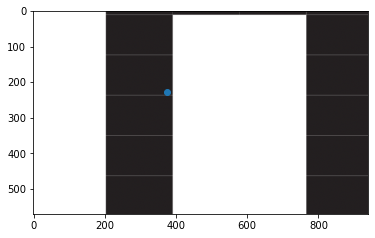

In [235]:
# for i in np.arange(0,2):
env = TemplateMatchingEnv(test_image_norm,
                          test_template_norm,
                          obs_shape_mult=(5,5),
                          sim_threshold=SIMILARTY_THRESHOLD)
env.reset()

fig,ax = plt.subplots()
ax.imshow(env.image_array)
gpd.GeoSeries(Point(env.frame_x_origin,env.frame_y_origin)).plot(ax=ax)

<AxesSubplot:>

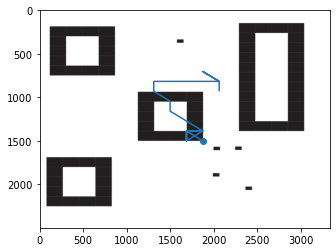

In [230]:
# look at path
fig,ax = plt.subplots()
ax.imshow(test_image_norm)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w


# line_string = ["LINESTRING (-1.15.12 9.9, -1.15.13 9.93)", "LINESTRING (-2.15.12 8.9, -2.15.13 8.93)"]
# invalid geometry - modified
points_rev = [(x[1],x[0]) for x in env.points]
gpd.GeoSeries(LineString(points_rev)).plot(ax=ax)
gpd.GeoSeries(Point(points_rev[0])).plot(ax=ax)


In [231]:
env.points

[(1500, 1875),
 (1386, 1687),
 (1500, 1687),
 (1386, 1875),
 (1386, 1687),
 (1500, 1687),
 (1386, 1687),
 (1386, 1875),
 (1272, 1687),
 (1158, 1499),
 (1044, 1499),
 (930, 1311),
 (816, 1311),
 (816, 1499),
 (816, 1687),
 (816, 1875),
 (816, 2063),
 (702, 1875),
 (816, 2063),
 (930, 2063)]

Clearing
EPISODE 2
Reset
Previous action was None
Moves left, 7
Action is 3, Northwest
SSD result is 47964.668788927345
Match


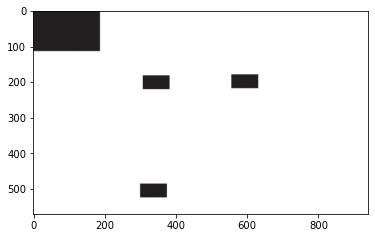

Previous action was 3
Moves left, 7
Action is 0, South
SSD result is 47964.668788927345
Match


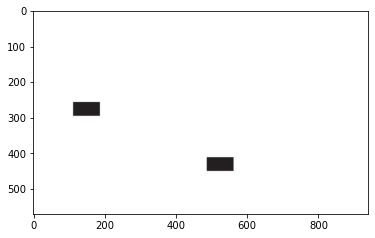

Previous action was 0
Moves left, 7
Action is 5, Northeast
SSD result is 47964.668788927345
Match


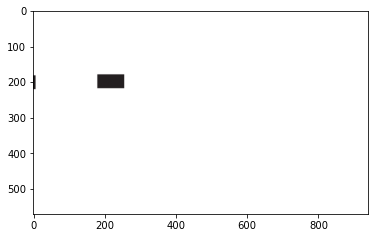

Previous action was 5
Moves left, 7
Action is 2, West
SSD result is 47964.668788927345
Match


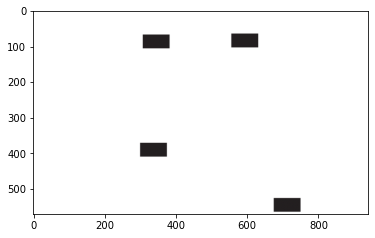

Previous action was 2
Moves left, 7
Action is 0, South
SSD result is 47964.668788927345
Match


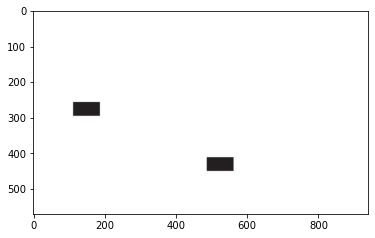

Previous action was 0
Moves left, 7
Action is 4, North
SSD result is 47964.668788927345
Match


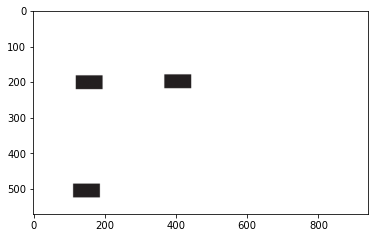

Previous action was 4
Moves left, 7
Action is 6, East
SSD result is 47964.668788927345
Match


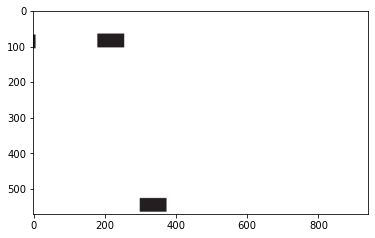

Previous action was 6
Moves left, 7
Action is 3, Northwest
SSD result is 47964.668788927345
Match


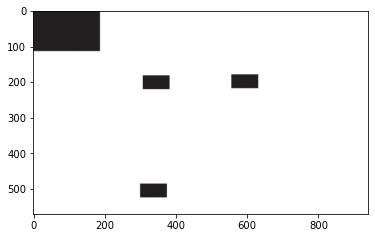

Previous action was 3
Moves left, 7
Action is 3, Northwest
SSD result is 47964.668788927345
Match


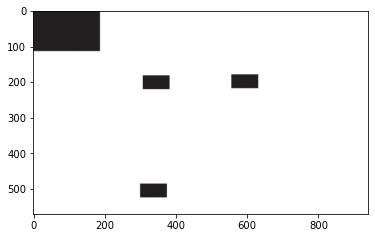

Previous action was 3
Moves left, 7
Action is 4, North
SSD result is 47964.668788927345
Match


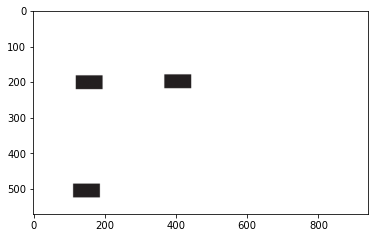

Previous action was 4
Moves left, 7
Action is 3, Northwest
SSD result is 47964.668788927345
Match


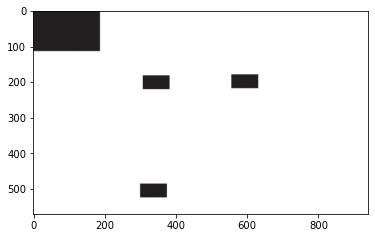

Previous action was 3
Moves left, 7
Action is 4, North
SSD result is 47964.668788927345
Match


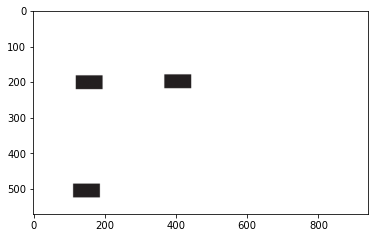

Previous action was 4
Moves left, 7
Action is 6, East
SSD result is 47964.668788927345
Match


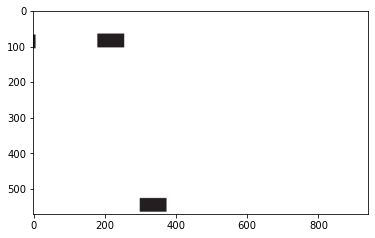

Previous action was 6
Moves left, 7
Action is 6, East
SSD result is 47964.668788927345
Match


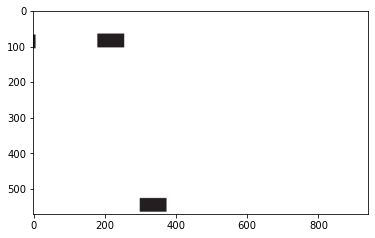

Previous action was 6
Moves left, 7
Action is 6, East
SSD result is 47964.668788927345
Match


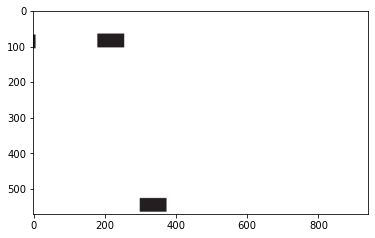

Previous action was 6
Moves left, 7
Action is 6, East
SSD result is 47964.668788927345
Match


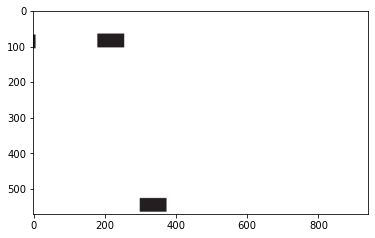

Previous action was 6
Moves left, 7
Action is 3, Northwest
SSD result is 47964.668788927345
Match


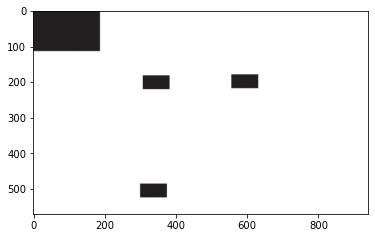

Previous action was 3
Moves left, 7
Action is 7, Southeast
SSD result is 47964.668788927345
Match


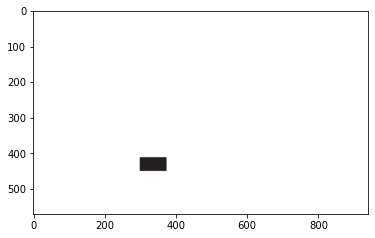

Previous action was 7
Moves left, 7
Action is 0, South
SSD result is 47964.668788927345
Match


KeyboardInterrupt: 

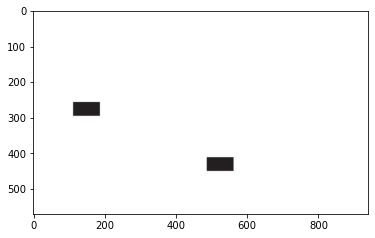

In [229]:
env = TemplateMatchingEnv(test_image_norm,
                          test_template_norm,
                          obs_shape_mult=(5,5),
                          sim_threshold=SIMILARTY_THRESHOLD)
rewards = []
for i in np.arange(0,4):
    print(f"EPISODE {i}")
    env.reset()
    while True:
        # Take a random action
        time.sleep(0.25)
        print(f"Previous action was {env.previous_action}")
        # action = random.choice(list(set([x for x in range(0, env.action_space.n)])
        #                             - set([action_rules(env.previous_action)])))
        obs, reward, done, info = env.step()
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        rewards.append(env.ep_return)
        
        
        if done == True:
            display.clear_output(wait=True)
            print("Clearing")
            # time.sleep(0.15)
            break
env.close()
print(f"Maximum reward achieved {max(rewards)}")


9

### Old Build

In [ ]:

class TemplateMatchingEnv_1(gym.Env):
  """A template matching environment for OpenAI gym"""
  metadata = {'render.modes': ['human']}
  def __init__(self, image_array, template_array):
    super(TemplateMatchingEnv, self).__init__()
    self.image_array = image_array
    self.template_array = template_array
    self.I_HEIGHT, self.I_WIDTH = image_array.shape
    self.T_HEIGHT, self.T_WIDTH = template_array.shape
    self.reward_range = (0, int(np.ceil((self.I_HEIGHT/self.T_HEIGHT)*2 + (self.I_WIDTH/self.T_WIDTH)*2)))
    
    # Action to choose the next agent location 
    # 0 -> 8 corresponds to the lsit of neighbor frames 
    self.action_space = spaces.Discrete(8, start=0)
    
    # Setting the observation space to be a frame of the whole image 
    # observation is also set to look at RGB
    self.observation_shape = (self.T_HEIGHT*10,self.T_WIDTH*10 , 1)
    self.observation_space = spaces.Box(low=0, high=255, shape=self.observation_shape, dtype=np.uint8)
  
  def reset(self):
    # Reset the state of the environment to an initial state
    # Set the current step to a random point within the data frame
    self.current_step = (random.randint(0, self.I_HEIGHT-self.T_HEIGHT),
                         random.randint(0, self.I_WIDTH-self.T_WIDTH)) # (y,x)
    return self._next_observation()
  
  def _next_observation(self):
    # Get the surrounding boxes
    # need to control for the edge conditions:
    rois = find_regions_interest(self.image_array,
                                 self.current_step[1],
                                 self.current_step[0],
                                 self.T_WIDTH,
                                 self.T_HEIGHT)
    return rois
  
  def step(self, action):
    # Execute one time step within the environment
    self._take_action(action)
    self.current_step += 1
    if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
      self.current_step = 0
    delay_modifier = (self.current_step / MAX_STEPS)
    
    reward = self.balance * delay_modifier
    done = self.net_worth <= 0
    obs = self._next_observation()
    print(obs)
    return obs, reward, done, {}

  def _take_action(self, action):
    # Set the current price to a random price within the time step
    current_price = random.uniform(
      self.df.loc[self.current_step, "Open"],
      self.df.loc[self.current_step, "Close"])
    action_type = action[0]
    amount = action[1]
    # if action_type < 1:
    #   # Buy amount % of balance in shares
    #   total_possible = self.balance / current_price
    #   shares_bought = total_possible * amount
    #   prev_cost = self.cost_basis * self.shares_held
    #   additional_cost = shares_bought * current_price
    #   self.balance -= additional_cost
    #   self.cost_basis = (prev_cost + additional_cost) / 
    #                           (self.shares_held + shares_bought)
    #   self.shares_held += shares_bought
    # elif actionType < 2:
    #   # Sell amount % of shares held
    #   shares_sold = self.shares_held * amount . 
    #   self.balance += shares_sold * current_price
    #   self.shares_held -= shares_sold
    #   self.total_shares_sold += shares_sold
    #   self.total_sales_value += shares_sold * current_price
    # self.netWorth = self.balance + self.shares_held * current_price
    # if self.net_worth > self.max_net_worth:
    #   self.max_net_worth = net_worth
    # if self.shares_held == 0:
    #   self.cost_basis = 0

In [ ]:
def train(env, agent, replay_buffer, T=20000, n_theta=100):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of
    '''
    

    # for plotting
    returns = []
    episode_rewards = 0

    s_t = env.reset()
    for t in range(T):
        # synchronize Q and Q_
        if t%n_theta == 0:
            agent.synchronize()

        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)

        # store data into replay buffer
        replay_buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next

        # learn by sampling from replay buffer
        for batch in replay_buffer.sample():
            agent.update(*batch)

        # for plotting
        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                returns.append(episode_rewards[i])
                episode_rewards[i] = 0

        # epsilon decay
        agent.decay_epsilon(t/T)

    plot_returns(returns)
    return agent

def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

In [ ]:
%%time

# global variables
SIMILARTY_THRESHOLD = 3362500
MAX_STEPS = 100
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = VectorizedEnvWrapper(TemplateMatchingEnv(image, template), num_envs=4)
agent = DeepQLearner(env, alpha=1e-3, gamma=0.95)
replay_buffer = ReplayBuffer(batch_size=1)
agent = train(env, agent, replay_buffer, T=20000)

### Trash

In [ ]:

## SCript to run the RL

# global variables
SIMILARTY_THRESHOLD = 0
MAX_STEPS = 2000
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = TemplateMatchingEnv(image, template)
model = DQN("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=MAX_STEPS)

model.save("/models/cnn_templatematch")  
model = DQN.load("/models/cnn_templatematch") 


# iterate the RL 
obs = env.reset()
for episode in np.arange(0,TOTAL_EPISODES): 
  action, _states = model.predict(obs, deterministic=True) # do something to illict an action 
  obs, rewards, done, info = env.step(action) # take a step based on the new action
  env.render()

NameError: name 'pd' is not defined